<a href="https://colab.research.google.com/github/CarlosSotero/Prevejendo_Resistencia_do_Concreto/blob/main/Desafio06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
# Montar o Drive (se estiver no Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import zscore

In [215]:
# Leitura da base de dados
df = pd.read_csv('/content/drive/MyDrive/DNC - Desafios/Desafio 6/dados_concreto - Sheet1.csv')
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength,Strength Category
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99,Alto
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89,Alto
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27,Baixa
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05,Baixa
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30,Baixa


In [216]:
# Verificar valores nulos e tipos
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cement                         2029 non-null   float64
 1   Blast Furnace Slag             2029 non-null   float64
 2   Fly Ash                        2029 non-null   float64
 3   Water                          2029 non-null   float64
 4   Superplasticizer               2029 non-null   float64
 5   Coarse Aggregate               2029 non-null   float64
 6   Fine Aggregate                 2029 non-null   float64
 7   Age                            2029 non-null   float64
 8   Concrete compressive strength  2020 non-null   float64
 9   Strength Category              2029 non-null   object 
dtypes: float64(9), object(1)
memory usage: 158.6+ KB


,0
Cement,0
Blast Furnace Slag,0
Fly Ash,0
Water,0
Superplasticizer,0
Coarse Aggregate,0
Fine Aggregate,0
Age,0
Concrete compressive strength,9
Strength Category,0


In [217]:
# Criando variável com os nomes das colunas de features do df
features = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age',]

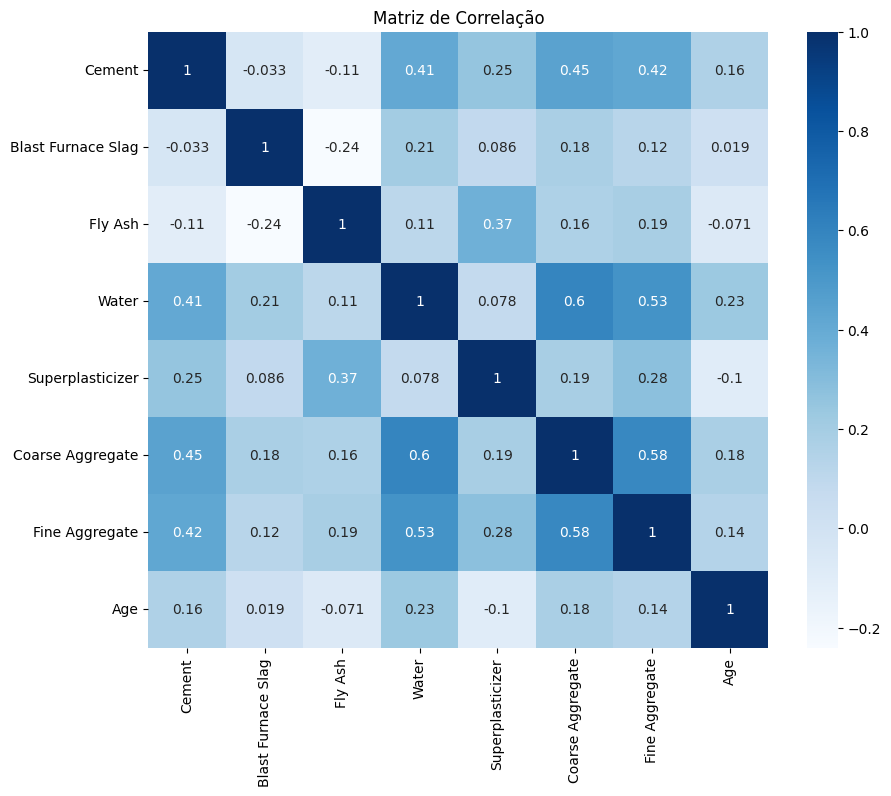

In [218]:
# Análise de correlação visual
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='Blues')
plt.title('Matriz de Correlação')
plt.show();

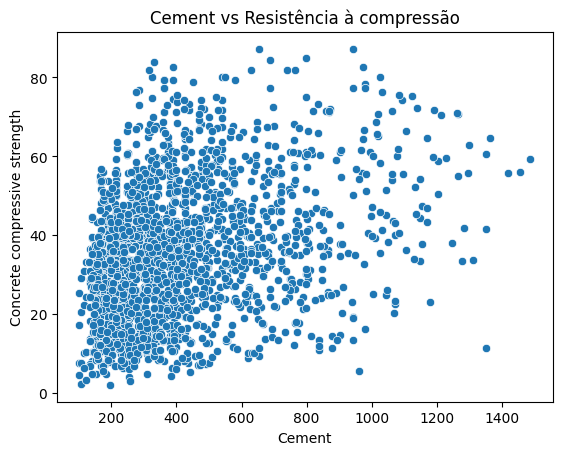

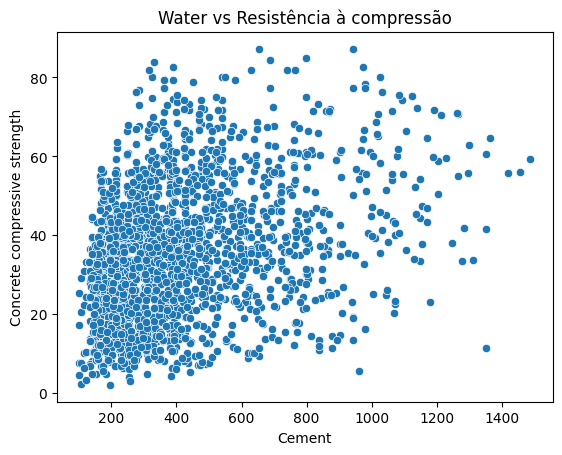

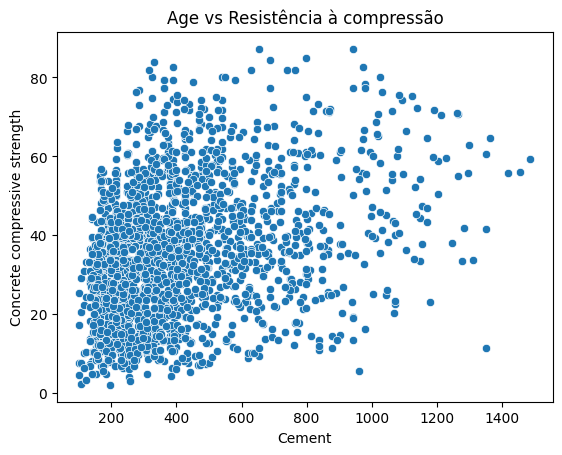

In [219]:
# Análise de dispersão em loop
variaveis = ['Cement', 'Water', 'Age']
for var in variaveis:
    sns.scatterplot(df, x='Cement', y='Concrete compressive strength')
    plt.title(f'{var} vs Resistência à compressão')
    plt.show()

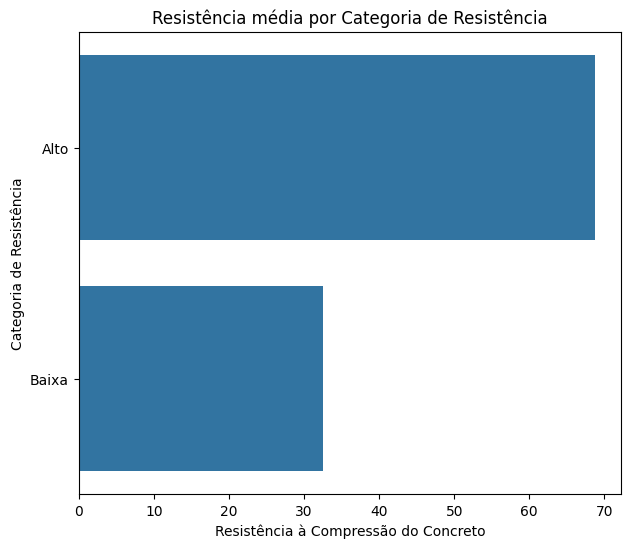

In [220]:
# Resistencia média por Strength Category
resistencia_media = df.groupby('Strength Category')['Concrete compressive strength'].mean()
# Adicioando como nome para as colunas
resistencia_media.columns = ['Strength Category', 'Concrete compressive strength']
# Resetando o index para ser um dataframe
resistencia_media = resistencia_media.reset_index()
# Plotando o gráfico de Resistência média por Categoria de resistência
plt.figure(figsize=(7,6))
sns.barplot(resistencia_media, y='Strength Category', x='Concrete compressive strength')
plt.title('Resistência média por Categoria de Resistência')
plt.xlabel('Resistência à Compressão do Concreto')
plt.ylabel('Categoria de Resistência')
plt.show();

<Axes: ylabel='Frequency'>

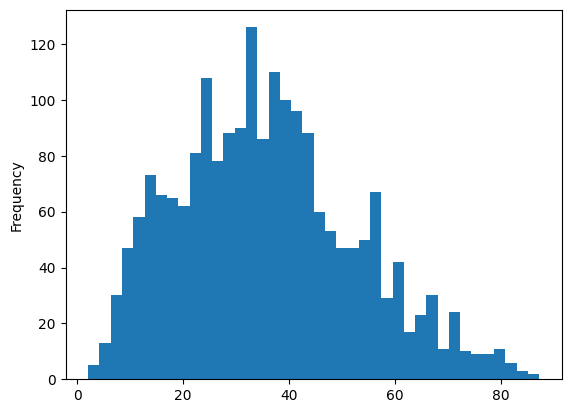

In [221]:
# Verificando a distribuição dos dados na variável 'Concrete compressive strength'
df['Concrete compressive strength'].plot(kind='hist', bins=40)

In [222]:
# Dropando linhas vazias
df = df.dropna()

# Função para suavizar os outliers
def suaviza_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=limite_inferior, upper=limite_superior)
    return df
# Criando uma cópia do df
df_suavizado = df.copy()
# Loop dentra
for col in features:
  df_suavizado = suaviza_outliers_iqr(df, col)

<ipython-input-222-fa8ce1b93e68>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].clip(lower=limite_inferior, upper=limite_superior)
<ipython-input-222-fa8ce1b93e68>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].clip(lower=limite_inferior, upper=limite_superior)
<ipython-input-222-fa8ce1b93e68>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [223]:
# Separar variáveis independentes e dependente
X = df.drop(['Concrete compressive strength','Strength Category'], axis=1)
y = df['Concrete compressive strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
# Modelo com Pipeline para o Random Forest
# Já utilizado o GridSearchCV para busca dos hiperparametros
pipeline_rf = Pipeline([
    ('modelo', RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# Validação Cruzada para o MAE
cv_results =  cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
# Validação Cruzada para o R2
cv_results_r2 =  cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='r2')

print('R2 do Random Forest:', r2_score(y_test, y_pred_rf))
print('MAE do Random Forest:', mean_absolute_error(y_test, y_pred_rf))
print('\nResultados da Validação Cruzada:')
print(f'R2 do Random Forest: {np.mean(cv_results_r2)}')
print(f'MAE do Random Forest: {np.mean(- cv_results)}')

R2 do Random Forest: 0.7796631606364104
MAE do Random Forest: 5.492476853562491

Resultados da Validação Cruzada:
R2 do Random Forest: 0.7724714237154728
MAE do Random Forest: 5.822189682445062


In [225]:
# Modelo com Pipeline: Regressão Linear
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('modelo', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# Validação Cruzada para o MAE
cv_results =  cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
# Validação Cruzada para o R2
cv_results_r2 =  cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='r2')

print('R2 da Regressão Linear:', r2_score(y_test, y_pred_lr))
print('MAE da Regressão Linear:', mean_absolute_error(y_test, y_pred_lr))
print('\nResultados da Validação Cruzada:')
print(f'R2 da Regressão Linear: {np.mean(cv_results_r2)}')
print(f'MAE da Regressão Linear: {np.mean(- cv_results)}')

R2 da Regressão Linear: 0.5075182067073456
MAE da Regressão Linear: 9.12981009487294

Resultados da Validação Cruzada:
R2 da Regressão Linear: 0.5114922189755741
MAE da Regressão Linear: 9.319185240685417


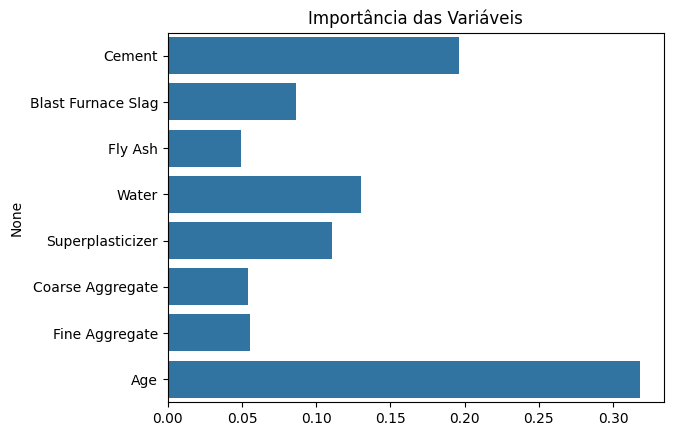

In [226]:
# Plotando gráfico para verificar as variáveis que mais influenciam o target
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
importancia = forest.feature_importances_
sns.barplot(x=importancia, y=X_train.columns)
plt.title('Importância das Variáveis')
plt.show()

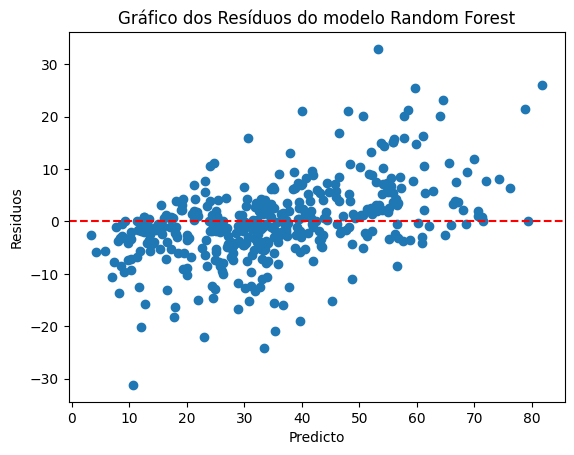

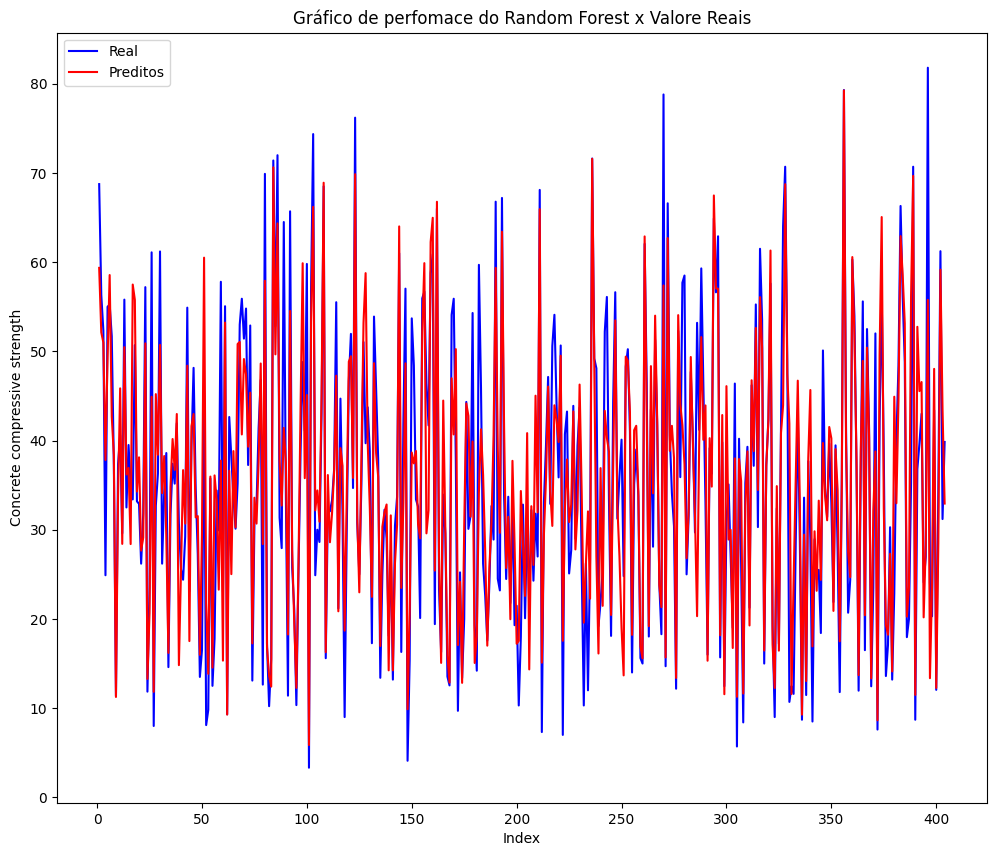

In [227]:
# Função para gerar plot dos resíduos do modelo Random Forest

def plot_residuals(y_true, y_pred):
  residuals = y_test - y_pred

  plt.scatter(y_true, residuals)
  plt.axhline(y=0, color="red", linestyle="--")

  plt.xlabel("Predicto")
  plt.ylabel("Residuos")
  plt.title('Gráfico dos Resíduos do modelo Random Forest')
  plt.show()

plot_residuals(y_test, y_pred_rf)
print('\n')

# Para percorrer o tamanho da base de teste
c = [i for i in range(1,405,1)]

# Definindo o tamanho do gráfico
fig = plt.figure(figsize=(12,10))

# Cor azul do gráfico para os valores de teste
plt.plot(c, y_test, color='blue', label='Real')

# Cor vermelha do gráfico para os valores que foram previstos
plt.plot(c, y_pred_rf, color='red', label='Preditos')

plt.title('Gráfico de perfomace do Random Forest x Valore Reais')
plt.xlabel('Index')
plt.ylabel('Concrete compressive strength')
plt.legend()
plt.show();

In [228]:
# Simulação de predição com novos dados
dados_simulacao = pd.DataFrame({
    'Cement': [550],
    'Blast Furnace Slag': [150],
    'Fly Ash': [0],
    'Water': [180],
    'Superplasticizer': [2.5],
    'Coarse Aggregate': [1000],
    'Fine Aggregate': [700],
    'Age': [25]
})

predict = pipeline_rf.predict(dados_simulacao)
print(f'Resistência prevista: {predict[0]:.2f}')
if predict < 60.1:
  print('Baixa Resistência!')
else:
  print('Alta Resistência!')

Resistência prevista: 53.36
Baixa Resistência!
